# Monte Carlo Simulation of Antibiotic Resistance Dynamics in Bacterial Populations

**Project Note**

This project was originally completed in 2023 as part of a course assignment from the online MIT OpenCourseWare course *Introduction to Computational Thinking and Data Science*.

It is reproduced here in notebook form for educational and portfolio purposes.
The only reference is the original problem set.

### 1. Introduction
This project employs a Monte Carlo stochastic framework to model bacterial population dynamics and to evaluate the effects of various antibiotic treatment regimens through repeated randomized simulations.

**Background: Bacteria and Antibiotics**

Bacteria are single-celled microorganisms that reproduce asexually. While many bacteria are harmless or beneficial, some can cause infectious diseases in humans. Antibiotics are medications designed to eliminate or inhibit the growth of pathogenic bacteria.

A major challenge in antibiotic treatment is the development of bacterial resistance. Bacteria can acquire resistance through natural genetic variation or through improper use of antibiotics, allowing resistant strains to survive and proliferate. This process can lead to rapid evolutionary changes in bacterial populations during treatment, making infections more difficult to control.


### 2. Helper Code: Imports and Utility Functions
   This section contains the required imports and helper functions used throughout the project.

In [2]:
# Imports
import math
import numpy as np
import pylab as pl
import random

# Custom Exception
class NoChildException(Exception):
    """
    NoChildException is raised by the reproduce() method in the SimpleBacteria
    and ResistantBacteria classes to indicate that a bacteria cell does not
    reproduce. You should use NoChildException as is; you do not need to
    modify it or add any code.
    """
# Plotting helper functions
def make_one_curve_plot(x_coords, y_coords, x_label, y_label, title):
    """
    Makes a plot of the x coordinates and the y coordinates with the labels
    and title provided.
    """
    pl.figure()
    pl.plot(x_coords, y_coords)
    pl.xlim(0, 300)
    pl.ylim(0)
    pl.xlabel(x_label)
    pl.ylabel(y_label)
    pl.title(title)
    pl.show()

def make_two_curve_plot(x_coords, y_coords1, y_coords2, y_name1, y_name2, x_label, y_label, title):
    """
    Makes a plot with two curves on it, based on the x coordinates with each of
    the set of y coordinates provided.
    """
    pl.figure()
    pl.plot(x_coords, y_coords1, label=y_name1)
    pl.plot(x_coords, y_coords2, label=y_name2)
    pl.legend()
    pl.xlim(0, 400)
    pl.ylim(0)
    pl.xlabel(x_label)
    pl.ylabel(y_label)
    pl.title(title)
    pl.show()

### 3. Modeling Bacteria and the Patient
A *SimpleBacteria* object represents a single bacterial cell without antibiotic resistance. At each discrete time step, the bacterium may die or reproduce according to fixed probabilities. Reproduction is further regulated by the population density.

In [3]:
class SimpleBacteria(object):
    """
    A simple bacteria cell with no antibiotic resistance.
    """

    def __init__(self, birth_prob, death_prob):
        self.birth_prob = birth_prob
        self.death_prob = death_prob

    def is_killed(self):
        """
        Returns True with probability equal to death_prob.
        """
        return random.random() < self.death_prob

    def reproduce(self, pop_density):
        """
        Reproduces with probability birth_prob * (1 - pop_density).
        """
        if random.random() < self.birth_prob * (1 - pop_density):
            return SimpleBacteria(self.birth_prob, self.death_prob)
        raise NoChildException

The *Patient* class represents the host environment in which bacteria evolve. It maintains a population of bacteria and updates the population state at each time step by applying death, density computation, and reproduction in sequence.

In [18]:
class Patient(object):  
    """
    Representation of a patient carrying a bacteria population.
    """

    def __init__(self, bacteria, max_pop):
        self.bacteria = bacteria
        self.max_pop = max_pop

    def get_total_pop(self):
        """
        Returns total bacteria population.
        """
        return len(self.bacteria)

    def update(self):
        """
        Executes one stochastic time step: death, density calculation,
        reproduction, and population update.
        """
        surviving_bacteria = []

        for bacterium in self.bacteria:
            if not bacterium.is_killed():
                surviving_bacteria.append(bacterium)

        pop_density = len(surviving_bacteria) / self.max_pop
        self.bacteria = surviving_bacteria.copy()

        for bacterium in surviving_bacteria:
            try:
                offspring = bacterium.reproduce(pop_density)
                self.bacteria.append(offspring)
            except NoChildException:
                pass

        return len(self.bacteria)

### 4. Simulation without Antibiotics
Since each simulation trial produces different stochastic outcomes, we compute the average population size across trials at a given time step. This average represents the expected population size under the model assumptions.

In [21]:
def calc_pop_avg(populations, n):
    """
    Compute the average bacteria population at time step n
    across multiple simulation trials.
    """
    total = 0
    count = 0

    for trial in populations:
        total += trial[n]
        count += 1

    return total / count

Each Monte Carlo trial simulates the evolution of a bacterial population over 300 time steps. The simulation starts with an initial number of bacteria and updates the population using the stochastic rules defined in Problem 1. The results of all trials are then averaged to observe the general population trend.

In [22]:
def simulation_without_antibiotic(num_bacteria, max_pop,
                                  birth_prob, death_prob,
                                  num_trials):
    """
    Run Monte Carlo simulations without antibiotic treatment and
    plot the average bacteria population over time.
    """
    populations = []

    for _ in range(num_trials):
        bacteria = [SimpleBacteria(birth_prob, death_prob)
                    for _ in range(num_bacteria)]
        patient = Patient(bacteria, max_pop)

        trial_pop = [patient.get_total_pop()]

        for _ in range(300):
            trial_pop.append(patient.update())

        populations.append(trial_pop)

    timesteps = list(range(301))
    avg_population = [calc_pop_avg(populations, t) for t in timesteps]

    make_one_curve_plot(timesteps, avg_population, "Time step", "Average population", "Bacteria population without antibiotics")

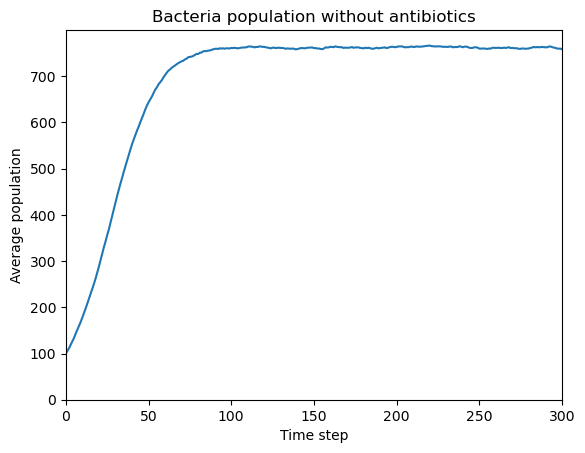

In [23]:
# Run the simulation
simulation_without_antibiotic(100, 1000, 0.1, 0.025, 50)

The curve shows an initial rapid increase in bacterial population followed by stabilization near the carrying capacity. This behavior results from decreasing reproduction probability as population density increases, combined with stochastic birth and death events.

This result is consistent with biological expectations, since higher population densities imply reduced availability of resources, which limits bacterial reproduction and leads to population stabilization.

### 5. Modeling Antibiotic Resistance and Treated Patient
*ResistantBacteria* extends the baseline *SimpleBacteria* model by adding antibiotic resistance as a heritable trait and allowing mutation during reproduction. This is the mechanism that lets resistance emerge and spread in the simulation.

In [27]:
class ResistantBacteria(SimpleBacteria):
    """A bacteria cell that can have antibiotic resistance."""

    def __init__(self, birth_prob, death_prob, resistant, mut_prob):
        super().__init__(birth_prob, death_prob)
        self.resistant = resistant
        self.mut_prob = mut_prob

    def get_resistant(self):
        return self.resistant

    def is_killed(self):
        if self.resistant:
            return random.random() < self.death_prob
        return random.random() < self.death_prob / 4

    def reproduce(self, pop_density):
        if random.random() < self.birth_prob * (1 - pop_density):
            # If already resistant, child is resistant.
            if self.resistant:
                return ResistantBacteria(self.birth_prob, self.death_prob, True, self.mut_prob)

            # If not resistant, child may mutate to resistant.
            if random.random() < self.mut_prob * (1 - pop_density):
                return ResistantBacteria(self.birth_prob, self.death_prob, True, self.mut_prob)

            return ResistantBacteria(self.birth_prob, self.death_prob, False, self.mut_prob)

        raise NoChildException

TreatedPatient extends Patient by adding an on_antibiotic state. Once antibiotics are administered, the patient remains on antibiotics permanently.
During updates, non-resistant bacteria are removed when antibiotics are active, while resistant bacteria continue to survive and reproduce normally

In [28]:
class TreatedPatient(Patient):
    """
    Patient that can receive antibiotics and carries ResistantBacteria.
    """

    def __init__(self, bacteria, max_pop):
        super().__init__(bacteria, max_pop)
        self.on_antibiotic = False

    def set_on_antibiotic(self):
        self.on_antibiotic = True

    def get_resist_pop(self):
        return sum(1 for b in self.bacteria if b.get_resistant())

    def update(self):
        surviving = []

        # 1) death + (2) antibiotic filtering (if active)
        for b in self.bacteria:
            if not b.is_killed():
                if (not self.on_antibiotic) or b.get_resistant():
                    surviving.append(b)

        # 3) density
        pop_density = len(surviving) / self.max_pop

        # 4) reproduction
        self.bacteria = surviving.copy()
        for b in surviving:
            try:
                self.bacteria.append(b.reproduce(pop_density))
            except NoChildException:
                pass

        return len(self.bacteria)

### 6. Simulation with Antibiotics

Run a Monte Carlo simulation where:
- the patient evolves 150 time steps without antibiotics
- then antibiotics are introduced and the simulation continues for 250 additional time steps

In [29]:
def simulation_with_antibiotic(num_bacteria, max_pop, birth_prob, death_prob, resistant, mut_prob, num_trials):
    """
    Run Monte Carlo simulations with antibiotic treatment.

    The simulation proceeds in two phases:
    - Phase 1: bacteria evolve without antibiotics
    - Phase 2: antibiotics are introduced and remain active
    """

    total_population = []
    resistant_population = []

    for _ in range(num_trials):
        # Initialize bacteria population
        bacteria = [
            ResistantBacteria(birth_prob, death_prob, resistant, mut_prob)
            for _ in range(num_bacteria)
        ]

        patient = TreatedPatient(bacteria, max_pop)

        trial_total = [patient.get_total_pop()]
        trial_resistant = [patient.get_resist_pop()]

        # Phase 1: without antibiotics (150 time steps)
        for _ in range(150):
            trial_total.append(patient.update())
            trial_resistant.append(patient.get_resist_pop())

        # Introduce antibiotics
        patient.set_on_antibiotic()

        # Phase 2: with antibiotics (250 time steps)
        for _ in range(250):
            trial_total.append(patient.update())
            trial_resistant.append(patient.get_resist_pop())

        total_population.append(trial_total)
        resistant_population.append(trial_resistant)
        # Compute averages
        timesteps = list(range(401))
        avg_total = [calc_pop_avg(total_population, t) for t in timesteps]
        avg_resistant = [calc_pop_avg(resistant_population, t) for t in timesteps]
    
        # Plot results
        make_two_curve_plot(
            timesteps,
            avg_total,
            avg_resistant,
            "Total Population",
            "Resistant Population",
            "Time step",
            "Average population",
            "Simulation with Antibiotics"
        )
    
        return total_population, resistant_population

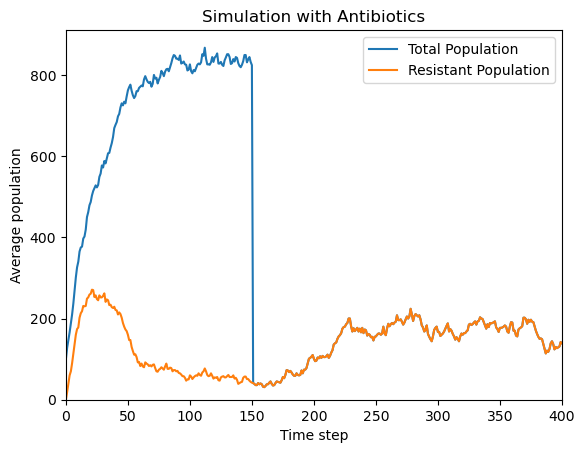

In [30]:
#Simulation A (higher birth_prob)
total_pop_A, resistant_pop_A = simulation_with_antibiotic(
    num_bacteria=100,
    max_pop=1000,
    birth_prob=0.3,
    death_prob=0.2,
    resistant=False,
    mut_prob=0.8,
    num_trials=50
)

- **Before antibiotics**:
  
The total bacterial population grows and stabilizes near the carrying capacity, while resistant bacteria remain rare and appear mainly through random mutation.
- **After antibiotics**:
  
The total population decreases sharply as non-resistant bacteria are eliminated, and resistant bacteria survive and often become dominant.

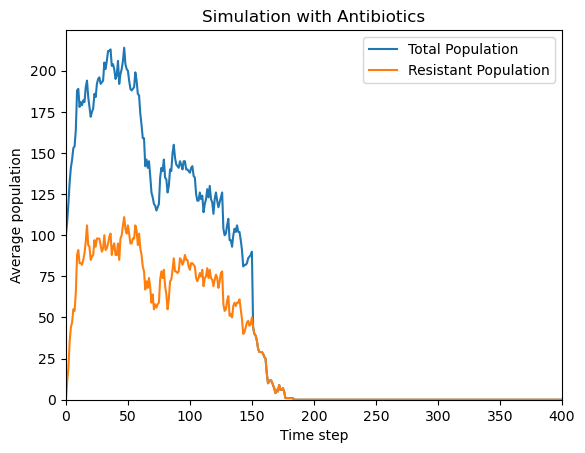

In [32]:
# Simulation B (lower birth_prob)
total_pop_B, resistant_pop_B = simulation_with_antibiotic(
    num_bacteria=100,
    max_pop=1000,
    birth_prob=0.17,
    death_prob=0.2,
    resistant=False,
    mut_prob=0.8,
    num_trials=50
)

In **Simulation B**, the lower birth rate prevents resistant bacteria from emerging before treatment, so antibiotics eliminate the entire population. This differs from **Simulation A**, where faster growth allows resistance to appear and survive after antibiotics.

### 7. Conclusion
This project applied a Monte Carlo to model bacterial population dynamics and antibiotic resistance. The results show that, without antibiotics, populations grow and stabilize due to limited resources. When antibiotics are introduced, non-resistant bacteria are eliminated, and survival depends on whether resistant strains have emerged beforehand. Faster-growing populations are more likely to develop resistance early and persist after treatment, while slower-growing populations may collapse entirely.